In [33]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

- resampling Measurement Data
- Aligning Solcast Data to Measurement Data
- period_start / period_mid / period_end

## Loading Data

In this example, our measurement data is:
  - 5minute averages
  - timestamps labelled with the period start
  - unknown timezone
  
which we want to compare to 15 minute Solcast data.

(N.B. if you do not know whether your measurement data is labelled with the start or end of the period, the best approach is to try assuming either way and seeing which gives you the best result)

In [ ]:
# retrieve relevant Solcast data
from solcast import historic

# NOTE: this will consume an API request!
resp = historic.radiation_and_weather(
    latitude=34.2547, longitude=-89.8729,
    # we get a buffer for this example, because we don't
    # know the timezone of our measurement data
    start="2023-01-14 00:00", end="2023-01-18 00:00",
    output_parameters=["ghi", "clearsky_ghi", "zenith"],
    period="PT15M",
)
solcast = resp.to_pandas()
# convert to tz-naive since we will be comparing 
# to measurements of unknown time zone.
solcast.index = solcast.index.tz_convert(None)  

solcast.head()

,ghi
period_start,
2023-01-15 00:00:00,0.0
2023-01-15 00:05:00,0.0
2023-01-15 00:10:00,0.0
2023-01-15 00:15:00,0.0
2023-01-15 00:20:00,0.0


<Axes: xlabel='period_start'>

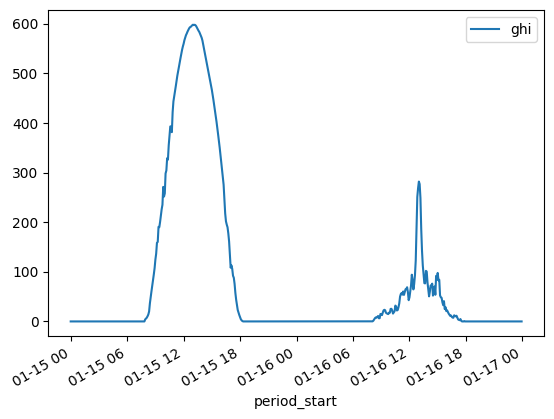

In [42]:
# load raw measurements
raw_measurements = pd.read_csv("3.1_sample_measurements.csv", index_col=0, parse_dates=True)

# clean up any clearly wrong values 
raw_measurements.loc[raw_measurements["ghi"]<0, "ghi"] = 0

display(raw_measurements.head())
raw_measurements.plot()

## Resampling Measurement Data

Here we resample measurement data to 15 minute averages, labelled with period_end

In [43]:
# In this example we are targeting 15 minute periods
target_minutes = 15
# we have 5 minute measurement data, so we expect
# 3 measurements per 15 minute period
minimum_measurements_per_period = 3
# if the raw_measurements are averaged by:
#   - period start, then closed="left"
#   - period end, then closed="right"
#   - instantaneous, then closed="right" 
#     (but you should ensure you have at least one-minute data!)
closed = "left"              

# label="right" to make the timestamp timestamps labelled with the period end
# (label="left" would make the timestamps labelled with the period start)
groupby = raw_measurements.resample(f"{target_minutes}T", label="right", closed=closed)
measurements_resampled = groupby.mean()
measurements_count = groupby.count()
measurements_resampled = measurements_resampled.where(measurements_count >= minimum_measurements_per_period)
measurements_resampled.index.name = "period_end"


Plotting up the results

- some times have been dropped to due incomplete measurements
- the PT15M timeseries is shifted to the right - this is expected, because multiple PT5M timestamps go into a single resampled timestamp, e.g.

```
resampled PT15M period_end | raw measurements PT5M period_starts 
12:45                      | [12:30, 12:35, 12:40]
13:00                      | [12:45, 12:50, 12:55]
...
```

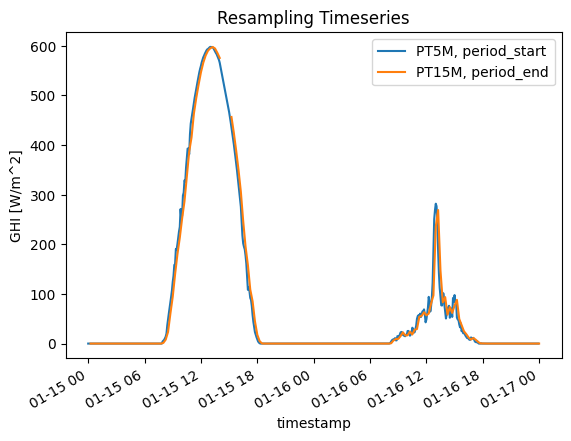

In [44]:
# plot up results
raw_measurements["ghi"].plot(label="PT5M, period_start")
measurements_resampled["ghi"].plot(label="PT15M, period_end")
plt.xlabel("timestamp")
plt.ylabel("GHI [W/m^2]")
plt.title("Resampling Timeseries")
plt.legend()
plt.show()

## Timezone Shifting Solcast Data

Here we detect the timezone of the measurements, and shift the Solcast Data to match this 

,ghi,clearsky_ghi,zenith
period_end,,,
2023-01-14 00:15:00,0,0,102
2023-01-14 00:30:00,0,0,105
2023-01-14 00:45:00,0,0,108
2023-01-14 01:00:00,0,0,111
2023-01-14 01:15:00,0,0,114
